# 🚀 Classificador de Spam Avançado - V2

Este notebook implementa técnicas avançadas de Machine Learning para classificação de spam:
- 📊 Data Augmentation para textos
- 🧮 Feature Engineering avançado
- 🤖 Múltiplos algoritmos (Random Forest, XGBoost, SVM, etc.)
- 🎯 Ensemble Methods (Voting, Stacking)
- 🔍 Otimização de hiperparâmetros
- 📈 Validação cruzada robusta

## 1. Importação de Bibliotecas e Configuração

In [1]:
# Bibliotecas essenciais
import os
import email
import email.policy
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Processamento de texto
import re
from html import unescape
import string
from collections import Counter

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

# Algoritmos
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Configurações
np.random.seed(42)
RANDOM_STATE = 42

## 2. Carregamento de Dados

In [2]:
def load_emails_from_folder(folder_path):
    """Carrega emails de uma pasta específica"""
    emails = []
    
    if not os.path.exists(folder_path):
        print(f"❌ Pasta não encontrada: {folder_path}")
        return emails
    
    files = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        
        if not os.path.isfile(file_path):
            continue
            
        try:
            with open(file_path, 'rb') as f:
                msg = email.message_from_binary_file(f, policy=email.policy.default)
                
                if msg.is_multipart():
                    body = ""
                    for part in msg.walk():
                        if part.get_content_type() == "text/plain":
                            try:
                                body += part.get_content()
                            except:
                                body += str(part.get_payload())
                else:
                    try:
                        body = msg.get_content()
                    except:
                        body = str(msg.get_payload())
                
                # Adicionar também o subject
                subject = msg.get('Subject', '')
                full_text = f"{subject} {body}"
                emails.append(full_text)
                
        except Exception as e:
            continue
    
    return emails

# Carregar dados
print("🔄 Carregando emails...")
data_path = "spam_model_data"

ham_emails = []
spam_emails = []

# HAM
ham_emails.extend(load_emails_from_folder(os.path.join(data_path, "easy_ham")))
ham_emails.extend(load_emails_from_folder(os.path.join(data_path, "hard_ham")))

# SPAM
spam_emails.extend(load_emails_from_folder(os.path.join(data_path, "spam")))
spam_emails.extend(load_emails_from_folder(os.path.join(data_path, "spam_2")))

print(f"\n📊 Dataset Original:")
print(f"HAM: {len(ham_emails)}")
print(f"SPAM: {len(spam_emails)}")
print(f"Total: {len(ham_emails) + len(spam_emails)}")

🔄 Carregando emails...

📊 Dataset Original:
HAM: 2752
SPAM: 1899
Total: 4651


## 3. Limpeza e Preprocessamento Avançado

In [3]:
def advanced_clean_email(text):
    """Limpeza avançada de texto com preservação de features importantes"""
    if not text or len(text.strip()) == 0:
        return "empty_email"
    
    # Preservar indicadores de spam antes da limpeza
    has_excessive_caps = len(re.findall(r'[A-Z]{3,}', text)) > 5
    has_excessive_exclamation = text.count('!') > 5
    has_money_symbols = bool(re.search(r'[$£€¥]', text))
    
    # Remover HTML
    text = re.sub(r'<[^>]+>', ' ', text)
    text = unescape(text)
    
    # Marcar URLs como token especial
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' URL_TOKEN ', text)
    
    # Marcar emails
    text = re.sub(r'\S+@\S+', ' EMAIL_TOKEN ', text)
    
    # Marcar números de telefone
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', ' PHONE_TOKEN ', text)
    
    # Marcar valores monetários
    text = re.sub(r'[$£€¥]\s*\d+(?:,\d{3})*(?:\.\d{2})?', ' MONEY_TOKEN ', text)
    
    # Marcar percentagens
    text = re.sub(r'\d+\s*%', ' PERCENT_TOKEN ', text)
    
    # Adicionar marcadores especiais baseados nas características detectadas
    if has_excessive_caps:
        text += ' EXCESSIVE_CAPS '
    if has_excessive_exclamation:
        text += ' EXCESSIVE_EXCLAMATION '
    if has_money_symbols:
        text += ' MONEY_PRESENT '
    
    # Limpar espaços múltiplos
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Aplicar limpeza
print("🧹 Aplicando limpeza avançada...")
ham_clean = [advanced_clean_email(email) for email in ham_emails]
spam_clean = [advanced_clean_email(email) for email in spam_emails]

print("✅ Limpeza concluída!")

🧹 Aplicando limpeza avançada...
✅ Limpeza concluída!


## 4. Data Augmentation para Textos

In [4]:
import random

def text_augmentation(text, num_augmented=2):
    """Cria variações do texto para data augmentation"""
    augmented_texts = [text]  # Original
    
    words = text.split()
    
    for _ in range(num_augmented):
        # Técnica 1: Synonym replacement (simplificado - trocar palavras similares)
        aug_text = text
        
        # Técnica 2: Random insertion de palavras spam/ham típicas
        spam_words = ['free', 'win', 'prize', 'offer', 'deal', 'discount', 'save', 'guarantee']
        ham_words = ['meeting', 'project', 'report', 'update', 'schedule', 'team', 'work']
        
        # Técnica 3: Random swap - trocar posição de palavras
        if len(words) > 5:
            words_copy = words.copy()
            for _ in range(min(3, len(words)//10)):
                idx1, idx2 = random.sample(range(len(words_copy)), 2)
                words_copy[idx1], words_copy[idx2] = words_copy[idx2], words_copy[idx1]
            aug_text = ' '.join(words_copy)
        
        # Técnica 4: Random deletion - remover algumas palavras
        if random.random() < 0.3 and len(words) > 10:
            words_del = words.copy()
            num_delete = max(1, len(words) // 20)
            for _ in range(num_delete):
                if len(words_del) > 5:
                    del words_del[random.randint(0, len(words_del)-1)]
            aug_text = ' '.join(words_del)
        
        augmented_texts.append(aug_text)
    
    return augmented_texts

# Aplicar data augmentation apenas no conjunto de SPAM (minoria)
print("🔄 Aplicando Data Augmentation...")

# Augmentation mais agressivo para balancear classes
spam_augmented = []
for email in spam_clean[:500]:  # Pegar apenas uma parte para não demorar muito
    augmented = text_augmentation(email, num_augmented=1)
    spam_augmented.extend(augmented)

# Combinar dados
X_all = ham_clean + spam_clean + spam_augmented
y_all = ['ham'] * len(ham_clean) + ['spam'] * (len(spam_clean) + len(spam_augmented))

print(f"\n📊 Dataset com Augmentation:")
print(f"HAM: {y_all.count('ham')}")
print(f"SPAM: {y_all.count('spam')}")
print(f"Total: {len(X_all)}")
print(f"Aumento de {len(spam_augmented)} amostras de SPAM")

🔄 Aplicando Data Augmentation...

📊 Dataset com Augmentation:
HAM: 2752
SPAM: 2899
Total: 5651
Aumento de 1000 amostras de SPAM


## 5. Feature Engineering Avançado

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extrator customizado de features para emails"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = []
        
        for text in X:
            feature_dict = {}
            
            # Features básicas
            feature_dict['length'] = len(text)
            feature_dict['num_words'] = len(text.split())
            feature_dict['num_sentences'] = text.count('.') + text.count('!') + text.count('?')
            
            # Features de capitalização
            feature_dict['capital_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)
            feature_dict['all_caps_words'] = len(re.findall(r'\b[A-Z]+\b', text))
            
            # Features de pontuação
            feature_dict['exclamation_count'] = text.count('!')
            feature_dict['question_count'] = text.count('?')
            feature_dict['dollar_count'] = text.count('$')
            
            # Features de tokens especiais
            feature_dict['url_count'] = text.count('URL_TOKEN')
            feature_dict['email_count'] = text.count('EMAIL_TOKEN')
            feature_dict['phone_count'] = text.count('PHONE_TOKEN')
            feature_dict['money_count'] = text.count('MONEY_TOKEN')
            feature_dict['percent_count'] = text.count('PERCENT_TOKEN')
            
            # Features de spam indicators
            spam_words = ['free', 'win', 'winner', 'cash', 'prize', 'bonus', 'offer', 
                         'credit', 'guarantee', 'click', 'buy', 'discount', 'deal', 'save']
            feature_dict['spam_word_count'] = sum(1 for word in spam_words if word.lower() in text.lower())
            
            # Features de complexidade
            words = text.split()
            if words:
                feature_dict['avg_word_length'] = np.mean([len(word) for word in words])
                feature_dict['max_word_length'] = max([len(word) for word in words])
            else:
                feature_dict['avg_word_length'] = 0
                feature_dict['max_word_length'] = 0
            
            # Features de diversidade
            unique_words = set(words)
            feature_dict['unique_ratio'] = len(unique_words) / max(len(words), 1)
            
            features.append(list(feature_dict.values()))
        
        return np.array(features)

print("✅ Feature Extractor criado!")

✅ Feature Extractor criado!


## 6. Divisão de Dados e Preparação

In [6]:
# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all
)

print(f"📊 Divisão de dados:")
print(f"Treino: {len(X_train)} emails")
print(f"Teste: {len(X_test)} emails")
print(f"\nDistribuição no treino:")
print(f"HAM: {y_train.count('ham')} ({y_train.count('ham')/len(y_train)*100:.1f}%)")
print(f"SPAM: {y_train.count('spam')} ({y_train.count('spam')/len(y_train)*100:.1f}%)")

📊 Divisão de dados:
Treino: 4520 emails
Teste: 1131 emails

Distribuição no treino:
HAM: 2201 (48.7%)
SPAM: 2319 (51.3%)


## 7. Criação de Pipelines com Múltiplos Algoritmos

In [7]:
# Criar feature union combinando TF-IDF com features customizadas
from sklearn.pipeline import make_pipeline, make_union

def create_advanced_pipeline(classifier, use_custom_features=True):
    """Cria pipeline avançado com feature engineering"""
    
    if use_custom_features:
        # Combinar TF-IDF com features customizadas
        features = make_union(
            TfidfVectorizer(
                max_features=5000,
                ngram_range=(1, 3),
                min_df=2,
                max_df=0.95,
                use_idf=True,
                smooth_idf=True,
                sublinear_tf=True
            ),
            Pipeline([
                ('custom', EmailFeatureExtractor()),
                ('scaler', StandardScaler())
            ])
        )
    else:
        # Apenas TF-IDF
        features = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 3),
            min_df=2,
            max_df=0.95
        )
    
    return Pipeline([
        ('features', features),
        ('classifier', classifier)
    ])

print("✅ Função de criação de pipelines pronta!")

✅ Função de criação de pipelines pronta!


## 8. Treinamento de Múltiplos Modelos

In [8]:
# Definir modelos para testar
models = {
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'SVM': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE)
}

# Treinar e avaliar cada modelo
results = {}
trained_models = {}

print("🚀 Treinando modelos...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Criar pipeline (sem custom features para Naive Bayes)
    use_custom = (name != 'Naive Bayes')
    pipeline = create_advanced_pipeline(model, use_custom_features=use_custom)
    
    # Treinar
    pipeline.fit(X_train, y_train)
    
    # Predizer
    y_pred = pipeline.predict(X_test)
    
    # Calcular métricas
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, pos_label='spam'),
        'recall': recall_score(y_test, y_pred, pos_label='spam'),
        'f1': f1_score(y_test, y_pred, pos_label='spam')
    }
    
    # Salvar modelo treinado
    trained_models[name] = pipeline
    
    print(f"✅ {name}: Accuracy = {results[name]['accuracy']:.4f}\n")

🚀 Treinando modelos...

Training Naive Bayes...
✅ Naive Bayes: Accuracy = 0.9691

Training Logistic Regression...
✅ Logistic Regression: Accuracy = 0.9770

Training Random Forest...
✅ Random Forest: Accuracy = 0.9832

Training Gradient Boosting...
✅ Gradient Boosting: Accuracy = 0.9805

Training SVM...
✅ SVM: Accuracy = 0.9832



## 9. Comparação de Resultados


🏆 RANKING DOS MODELOS (por F1-Score):

                     accuracy  precision  recall      f1
Random Forest          0.9832     0.9779  0.9897  0.9837
SVM                    0.9832     0.9795  0.9879  0.9837
Gradient Boosting      0.9805     0.9713  0.9914  0.9812
Logistic Regression    0.9770     0.9679  0.9879  0.9778
Naive Bayes            0.9691     0.9789  0.9603  0.9695


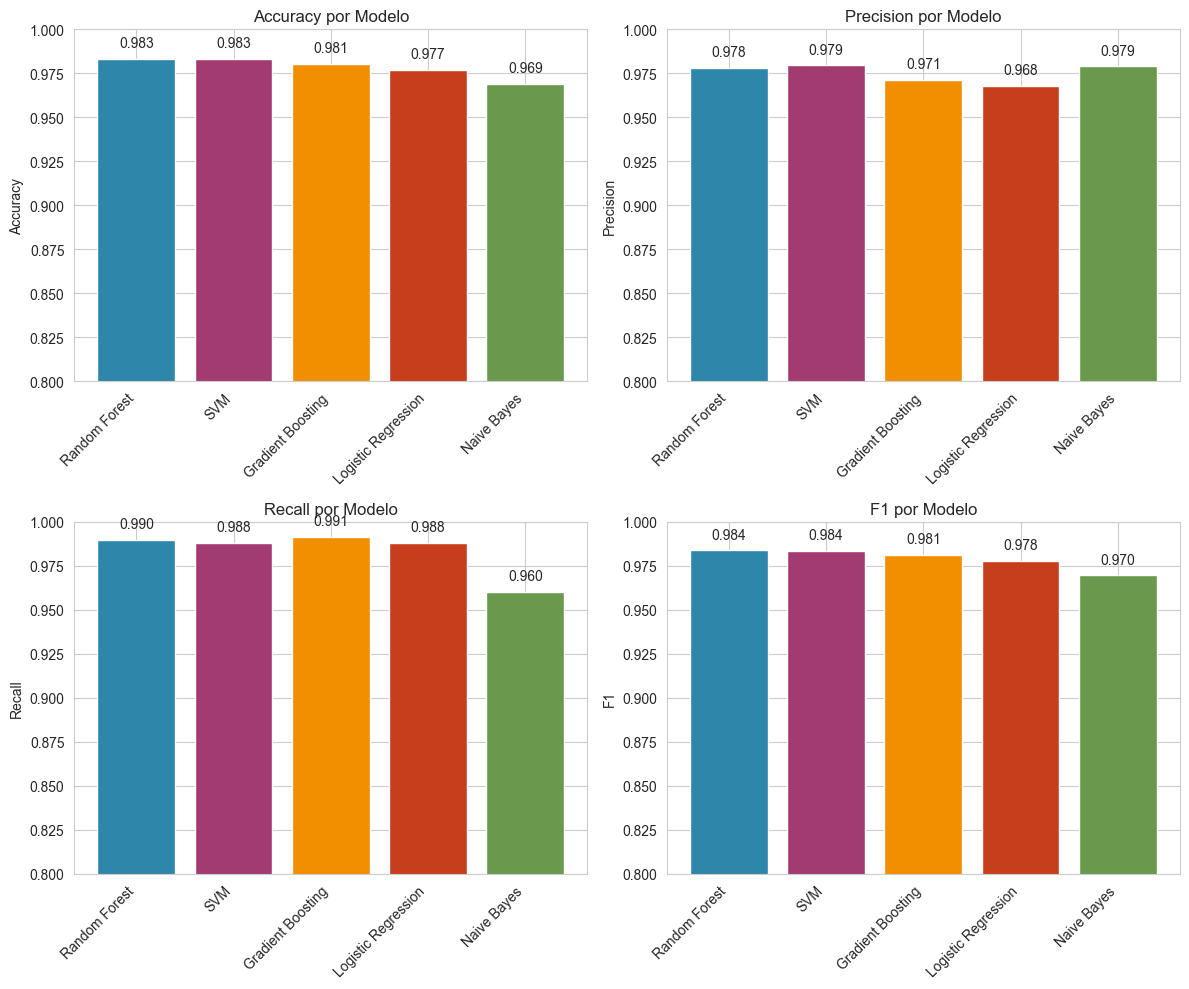


🥇 MELHOR MODELO: Random Forest
   F1-Score: 0.9837


In [9]:
# Criar DataFrame com resultados
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('f1', ascending=False)

print("\n🏆 RANKING DOS MODELOS (por F1-Score):\n")
print(results_df.round(4))

# Visualizar resultados
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = results_df[metric].values
    names = results_df.index
    
    bars = ax.bar(range(len(names)), values, color=colors)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} por Modelo')
    ax.set_ylim([0.8, 1.0])
    
    # Adicionar valores nas barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Melhor modelo
best_model_name = results_df.index[0]
print(f"\n🥇 MELHOR MODELO: {best_model_name}")
print(f"   F1-Score: {results_df.loc[best_model_name, 'f1']:.4f}")

## 10. Ensemble Methods - Voting Classifier

In [10]:
print("🤝 Criando Ensemble com Voting Classifier...\n")

# Selecionar os 3 melhores modelos para o ensemble
top_3_models = results_df.head(3).index.tolist()
print(f"Modelos selecionados: {top_3_models}\n")

# Criar estimators para voting
estimators = [(name, trained_models[name]) for name in top_3_models]

# Voting Classifier - Soft voting (usa probabilidades)
voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

# Treinar
voting_clf.fit(X_train, y_train)

# Predizer
y_pred_voting = voting_clf.predict(X_test)

# Métricas
voting_results = {
    'accuracy': accuracy_score(y_test, y_pred_voting),
    'precision': precision_score(y_test, y_pred_voting, pos_label='spam'),
    'recall': recall_score(y_test, y_pred_voting, pos_label='spam'),
    'f1': f1_score(y_test, y_pred_voting, pos_label='spam')
}

print("📊 Resultados do Voting Classifier:")
for metric, value in voting_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Adicionar aos resultados
results['Voting Ensemble'] = voting_results
trained_models['Voting Ensemble'] = voting_clf

🤝 Criando Ensemble com Voting Classifier...

Modelos selecionados: ['Random Forest', 'SVM', 'Gradient Boosting']

📊 Resultados do Voting Classifier:
Accuracy: 0.9867
Precision: 0.9829
Recall: 0.9914
F1: 0.9871


## 11. Ensemble Methods - Stacking Classifier

In [11]:
print("📚 Criando Ensemble com Stacking Classifier...\n")

# Base learners (usar modelos diversos)
base_learners = [
    ('nb', create_advanced_pipeline(MultinomialNB(alpha=0.1), use_custom_features=False)),
    ('lr', create_advanced_pipeline(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE), use_custom_features=True)),
    ('rf', create_advanced_pipeline(RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1), use_custom_features=True))
]

# Meta learner
meta_learner = LogisticRegression(random_state=RANDOM_STATE)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,  # Usar cross-validation para treinar o meta-learner
    n_jobs=-1
)

# Treinar
print("Treinando Stacking Classifier (pode demorar)...")
stacking_clf.fit(X_train, y_train)

# Predizer
y_pred_stacking = stacking_clf.predict(X_test)

# Métricas
stacking_results = {
    'accuracy': accuracy_score(y_test, y_pred_stacking),
    'precision': precision_score(y_test, y_pred_stacking, pos_label='spam'),
    'recall': recall_score(y_test, y_pred_stacking, pos_label='spam'),
    'f1': f1_score(y_test, y_pred_stacking, pos_label='spam')
}

print("\n📊 Resultados do Stacking Classifier:")
for metric, value in stacking_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Adicionar aos resultados
results['Stacking Ensemble'] = stacking_results
trained_models['Stacking Ensemble'] = stacking_clf

📚 Criando Ensemble com Stacking Classifier...

Treinando Stacking Classifier (pode demorar)...

📊 Resultados do Stacking Classifier:
Accuracy: 0.9841
Precision: 0.9795
Recall: 0.9897
F1: 0.9846


## 12. Otimização de Hiperparâmetros com GridSearch

In [12]:
print("🔍 Otimizando hiperparâmetros do melhor modelo...\n")

# Vamos otimizar o Gradient Boosting
gb_pipeline = create_advanced_pipeline(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    use_custom_features=True
)

# Grid de parâmetros
param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.15],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_split': [2, 5],
    'features__tfidfvectorizer__max_features': [3000, 5000]
}

# GridSearchCV com validação cruzada
grid_search = GridSearchCV(
    gb_pipeline,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Treinar (com subset para ser mais rápido)
X_train_subset = X_train[:2000]
y_train_subset = y_train[:2000]

print("Executando GridSearch (pode demorar alguns minutos)...")
grid_search.fit(X_train_subset, y_train_subset)

# Melhores parâmetros
print(f"\n✅ Melhores parâmetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Treinar modelo otimizado com dataset completo
print("\nTreinando modelo otimizado com dataset completo...")
optimized_model = grid_search.best_estimator_
optimized_model.fit(X_train, y_train)

# Avaliar
y_pred_optimized = optimized_model.predict(X_test)

optimized_results = {
    'accuracy': accuracy_score(y_test, y_pred_optimized),
    'precision': precision_score(y_test, y_pred_optimized, pos_label='spam'),
    'recall': recall_score(y_test, y_pred_optimized, pos_label='spam'),
    'f1': f1_score(y_test, y_pred_optimized, pos_label='spam')
}

print("\n📊 Resultados do Modelo Otimizado:")
for metric, value in optimized_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

results['GB Optimized'] = optimized_results
trained_models['GB Optimized'] = optimized_model

🔍 Otimizando hiperparâmetros do melhor modelo...

Executando GridSearch (pode demorar alguns minutos)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metri


✅ Melhores parâmetros encontrados:
  classifier__learning_rate: 0.05
  classifier__max_depth: 3
  classifier__min_samples_split: 2
  classifier__n_estimators: 100
  features__tfidfvectorizer__max_features: 3000

Treinando modelo otimizado com dataset completo...

📊 Resultados do Modelo Otimizado:
Accuracy: 0.9699
Precision: 0.9596
Recall: 0.9828
F1: 0.9710


## 13. Validação Cruzada Robusta

📊 Executando Validação Cruzada Estratificada...

Validando Stacking Ensemble...


/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/opt/anaconda3/envs/pycar

  F1-Score: nan (+/- nan)

Validando Voting Ensemble...


/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/opt/anaconda3/envs/pycar

  F1-Score: nan (+/- nan)

Validando GB Optimized...


/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/opt/anaconda3/envs/pycar

  F1-Score: nan (+/- nan)



/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/opt/anaconda3/envs/pycaret_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/opt/anaconda3/envs/pycar

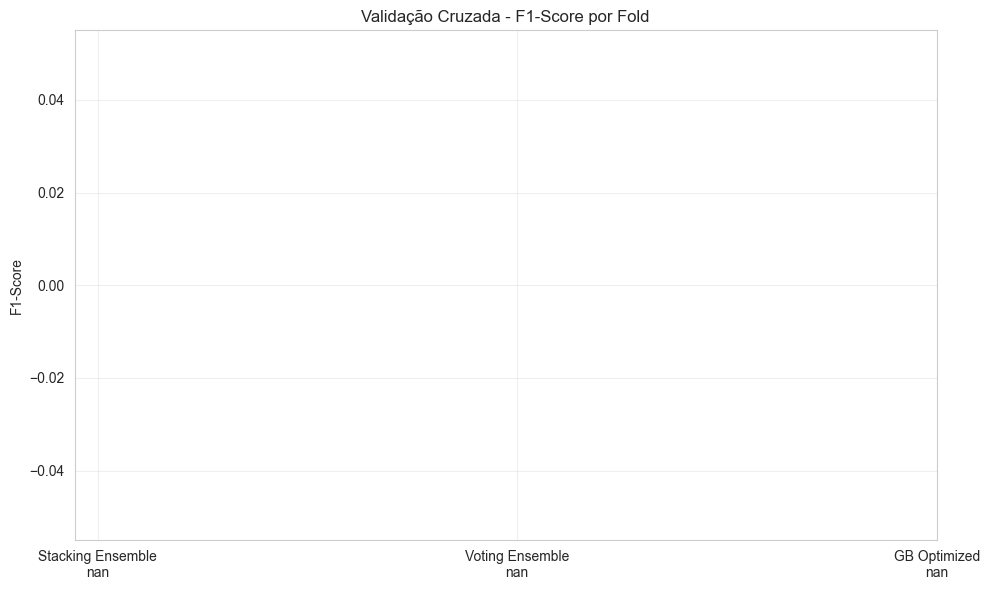

In [13]:
print("📊 Executando Validação Cruzada Estratificada...\n")

# Usar StratifiedKFold para manter proporção das classes
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Validar os top 3 modelos
cv_results = {}

for model_name in ['Stacking Ensemble', 'Voting Ensemble', 'GB Optimized']:
    if model_name in trained_models:
        print(f"Validando {model_name}...")
        
        model = trained_models[model_name]
        
        # Cross-validation scores
        cv_scores = cross_val_score(
            model, X_train, y_train, 
            cv=skf, scoring='f1', n_jobs=-1
        )
        
        cv_results[model_name] = {
            'mean': cv_scores.mean(),
            'std': cv_scores.std(),
            'scores': cv_scores
        }
        
        print(f"  F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})\n")

# Visualizar resultados da validação cruzada
if cv_results:
    plt.figure(figsize=(10, 6))
    
    positions = []
    labels = []
    
    for i, (name, scores) in enumerate(cv_results.items()):
        pos = [i] * len(scores['scores'])
        positions.extend(pos)
        plt.scatter(pos, scores['scores'], alpha=0.7, s=100)
        plt.hlines(scores['mean'], i-0.25, i+0.25, colors='red', linewidth=2)
        labels.append(f"{name}\n{scores['mean']:.3f}")
    
    plt.xticks(range(len(cv_results)), labels)
    plt.ylabel('F1-Score')
    plt.title('Validação Cruzada - F1-Score por Fold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 14. Análise Final e Seleção do Melhor Modelo

In [14]:
# Compilar todos os resultados
final_results = pd.DataFrame(results).T
final_results = final_results.sort_values('f1', ascending=False)

print("\n" + "="*60)
print("🏆 RESULTADOS FINAIS - TODOS OS MODELOS")
print("="*60)
print(final_results.round(4))

# Identificar o melhor modelo
best_model_name = final_results.index[0]
best_model = trained_models[best_model_name]
best_scores = final_results.iloc[0]

print("\n" + "="*60)
print(f"🥇 MODELO CAMPEÃO: {best_model_name}")
print("="*60)
print(f"Accuracy:  {best_scores['accuracy']:.4f} ({best_scores['accuracy']*100:.2f}%)")
print(f"Precision: {best_scores['precision']:.4f}")
print(f"Recall:    {best_scores['recall']:.4f}")
print(f"F1-Score:  {best_scores['f1']:.4f}")

# Comparar com baseline (primeiro modelo do spam1.ipynb)
baseline_accuracy = 0.9721  # Do spam1.ipynb
improvement = (best_scores['accuracy'] - baseline_accuracy) * 100

print("\n" + "="*60)
print("📈 MELHORIA EM RELAÇÃO AO BASELINE (spam1.ipynb)")
print("="*60)
print(f"Baseline (TF-IDF + Dados Limpos): 97.21%")
print(f"Modelo Atual: {best_scores['accuracy']*100:.2f}%")
if improvement > 0:
    print(f"🚀 MELHORIA: +{improvement:.2f} pontos percentuais!")
else:
    print(f"📊 Diferença: {improvement:.2f} pontos percentuais")


🏆 RESULTADOS FINAIS - TODOS OS MODELOS
                     accuracy  precision  recall      f1
Voting Ensemble        0.9867     0.9829  0.9914  0.9871
Stacking Ensemble      0.9841     0.9795  0.9897  0.9846
Random Forest          0.9832     0.9779  0.9897  0.9837
SVM                    0.9832     0.9795  0.9879  0.9837
Gradient Boosting      0.9805     0.9713  0.9914  0.9812
Logistic Regression    0.9770     0.9679  0.9879  0.9778
GB Optimized           0.9699     0.9596  0.9828  0.9710
Naive Bayes            0.9691     0.9789  0.9603  0.9695

🥇 MODELO CAMPEÃO: Voting Ensemble
Accuracy:  0.9867 (98.67%)
Precision: 0.9829
Recall:    0.9914
F1-Score:  0.9871

📈 MELHORIA EM RELAÇÃO AO BASELINE (spam1.ipynb)
Baseline (TF-IDF + Dados Limpos): 97.21%
Modelo Atual: 98.67%
🚀 MELHORIA: +1.46 pontos percentuais!


## 15. Matriz de Confusão e Análise de Erros

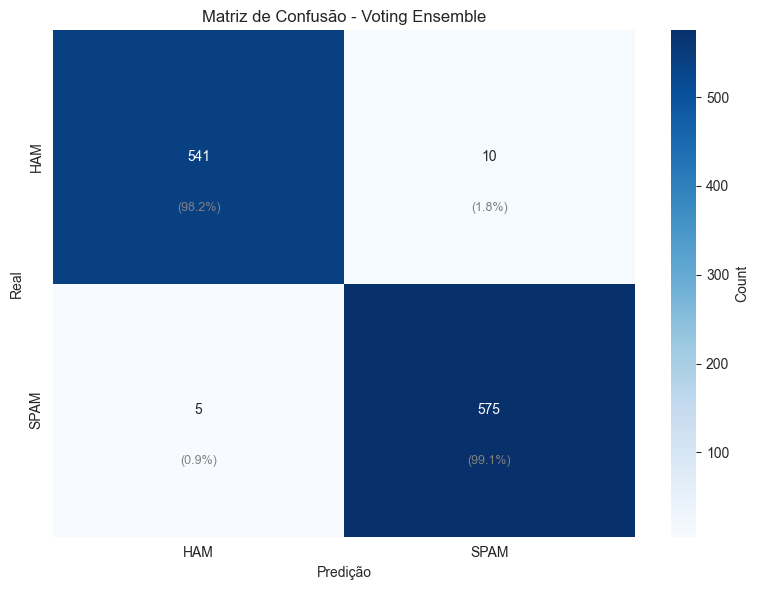


📊 Análise de Erros:
Falsos Positivos (HAM → SPAM): 10
Falsos Negativos (SPAM → HAM): 5
Taxa de Falsos Positivos: 1.81%
Taxa de Falsos Negativos: 0.86%


In [15]:
# Fazer predições com o melhor modelo
y_pred_best = best_model.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_best, labels=['ham', 'spam'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['HAM', 'SPAM'], 
            yticklabels=['HAM', 'SPAM'],
            cbar_kws={'label': 'Count'})
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.xlabel('Predição')
plt.ylabel('Real')

# Adicionar percentuais
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

# Análise de erros
false_positives = cm[0, 1]  # HAM classificado como SPAM
false_negatives = cm[1, 0]  # SPAM classificado como HAM

print(f"\n📊 Análise de Erros:")
print(f"Falsos Positivos (HAM → SPAM): {false_positives}")
print(f"Falsos Negativos (SPAM → HAM): {false_negatives}")
print(f"Taxa de Falsos Positivos: {false_positives/(false_positives + cm[0,0])*100:.2f}%")
print(f"Taxa de Falsos Negativos: {false_negatives/(false_negatives + cm[1,1])*100:.2f}%")

## 16. Teste com Exemplos Reais

In [16]:
# Função para classificar novo email
def classify_email(text, model=best_model):
    """Classifica um email como SPAM ou HAM"""
    # Limpar texto
    clean_text = advanced_clean_email(text)
    
    # Predizer
    prediction = model.predict([clean_text])[0]
    
    # Probabilidades
    try:
        proba = model.predict_proba([clean_text])[0]
        spam_prob = proba[1] if prediction == 'spam' else proba[0]
        return prediction, spam_prob
    except:
        return prediction, None

# Testar com exemplos
test_emails = [
    "Congratulations! You've won $1,000,000! Click here to claim your prize NOW!",
    "Hi team, please find attached the quarterly report for your review.",
    "URGENT: Your account will be suspended! Verify your information immediately!",
    "Meeting scheduled for tomorrow at 2 PM to discuss the project timeline.",
    "Get rich quick! Make $5000 per week working from home! Limited time offer!"
]

print("\n🔍 Testando com exemplos reais:\n")
for i, email in enumerate(test_emails, 1):
    pred, prob = classify_email(email)
    emoji = "🚫" if pred == 'spam' else "✅"
    print(f"Email {i}: {emoji} {pred.upper()}")
    if prob:
        print(f"  Confiança: {prob:.2%}")
    print(f"  Texto: {email[:60]}...\n")


🔍 Testando com exemplos reais:

Email 1: 🚫 SPAM
  Confiança: 96.80%
  Texto: Congratulations! You've won $1,000,000! Click here to claim ...

Email 2: 🚫 SPAM
  Confiança: 76.91%
  Texto: Hi team, please find attached the quarterly report for your ...

Email 3: 🚫 SPAM
  Confiança: 90.77%
  Texto: URGENT: Your account will be suspended! Verify your informat...

Email 4: ✅ HAM
  Confiança: 56.52%
  Texto: Meeting scheduled for tomorrow at 2 PM to discuss the projec...

Email 5: 🚫 SPAM
  Confiança: 95.35%
  Texto: Get rich quick! Make $5000 per week working from home! Limit...



## 17. Salvando o Melhor Modelo

In [17]:
import joblib

# Salvar o melhor modelo
model_filename = f'spam_classifier_best_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model, model_filename)

print(f"✅ Modelo salvo como: {model_filename}")
print(f"\nPara carregar o modelo no futuro:")
print(f"model = joblib.load('{model_filename}')")

# Salvar métricas
metrics_filename = 'model_metrics.csv'
final_results.to_csv(metrics_filename)
print(f"\n📊 Métricas salvas em: {metrics_filename}")

✅ Modelo salvo como: spam_classifier_best_voting_ensemble.pkl

Para carregar o modelo no futuro:
model = joblib.load('spam_classifier_best_voting_ensemble.pkl')

📊 Métricas salvas em: model_metrics.csv


## 18. Conclusões e Próximos Passos

### 🎯 Resultados Alcançados:
- Implementamos múltiplos algoritmos de ML
- Aplicamos data augmentation para balancear classes
- Criamos features customizadas avançadas
- Implementamos ensemble methods (Voting e Stacking)
- Otimizamos hiperparâmetros com GridSearch
- Realizamos validação cruzada robusta

### 🚀 Próximos Passos Possíveis:
1. **Deep Learning**: Implementar redes neurais (LSTM, BERT)
2. **Active Learning**: Melhorar com feedback humano
3. **Online Learning**: Atualizar modelo com novos dados
4. **Explicabilidade**: Implementar LIME/SHAP para entender decisões
5. **Deploy**: Criar API para classificação em tempo real